In [1]:
#!/usr/bin/python3

## Illustration de l'article Inria Interstices...

**Mode d'emploi :**   
* Cette page est une succession de cases ("cellules") de texte et de code python. Ces dernières sont repérables par la mention "Entrée [1]", "Entrée [2]", etc. sur la gauche dans la marge.
* Vous pouvez exécuter une succession de cellules de code python pour effectuer une nouvelle simulation ou pour reproduire une simulation
* Deux méthodes sont possibles : 
   * Soit cliquer sur chaque cellule puis sur l'icône "Exécuter" ci-dessous (triangle pointant vers la droite). Notez que le curseur se déplace automatiquement sur la cellule suivante: il est dès lors inutile de cliquer sur la cellule de nouveau. Cliquer plusieurs fois de suite sur "Exécuter" provoquera l'exécution des cellules successives.
   * Soit cliquer sur "Cell" dans le menu ci-dessus, puis "Run All", ce qui provoquera l'exécution des cellules.
   * Le paramétrage de la simulation se fait via les cellules [7] / [8] : entre les deux se trouve un curseur utilisé pour régler l'intensité de la dépendance entre valeurs simulées voisines.

Que vous soyez expert.e ou non en python, vous pouvez modifier le contenu de ce programme sans que cela n'ait d'effet sur son utilisation par d'autres personnes. Vous pouvez revenir à l'état initial du programme en cliquant sur le menu "Fichier" puis "Fermer et arrêter" puis en redémarrant la page via l'onglet intitulé "Home Page - Select or create a notebook"

**Rappel du lien entre ce programme de simulation et le contenu de l'article Interstices :**   
Le programme ci-dessous permet de simuler des données dépendantes sur un graphe connu. Dans le contexte d'analyse de signaux EEG, il faut s'imaginer une donnée comme la valeur du signal EEG à un instant fixé. Chaque région cérébrale est représentée par un nœud du graphe et chaque connexion est représentée par une arête du graphe. Les valeurs simulées doivent l'être en respectant les dépendances induites par les connexions entre régions. La simulation est basée sur une loi de probabilité relative à ces valeurs, telle  que la valeur d'un nœud est une moyenne des valeurs des nœuds voisins, plus un bruit. En réalité la problématique abordée ci-dessus en neurosciences relève plutôt d'un problème inverse : à partir de la valeur observée en chaque nœud, l'analyse statistique vise à retrouver le graphe des connexions. Une autre manière de voir le problème direct est de l'assimiler à un programme aléatoire qui part d'un graphe connu pour générer des données et le problème inverse, comme un programme qui part de données et vise à retrouver le graphe sous-jacent au problème direct.


### Simulation de données gaussiennes dépendantes sur graphe

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

import os

from pathlib import Path


prefix_donnees = "graph_data"

chemin_donnees = prefix_donnees + ".txt"

# Type de graphe de voisinage
nom_graphe = "Delaunay"
k = 3
distance = 500

import pandas as pd
df = pd.read_csv(chemin_donnees)
df = df.dropna(subset=["Longest_Length"])
x = np.array(df["Xcoordinates"])
y = np.array(df["Ycoordinates"])


## Construit le graphe de Delaunay 
Étant donné une configuration de points dans un espace en deux dimensions (chaque point étant repéré par une abscisse *x* et une ordonnée *y*), le graphe de Delaunay est une collection de triangles ayant ces points pour sommets, telle qu'aucun point n'est à l'intérieur du cercle circonscrit d'un des triangles.   
Une définition plus détaillée est disponible sur https://fr.wikipedia.org/wiki/Triangulation_de_Delaunay   
Ici cette approche est utilisée comme méthode de construction de graphe à partir d'un ensemble de points (noter qu'il existe également d'autres approches)

In [3]:
# chemin vers repertoire "lib"
chemin_lib = os.path.join(os.getcwd(), "lib")
import sys  
sys.path.insert(0, chemin_lib)

from graph import creatGraph

w = creatGraph(prefix_donnees,"",nom_graphe,k,distance)

import networkx as nx

G = w.to_networkx()

/home/durand/anaconda3/envs/interstices_neuro/lib/python3.9/site-packages/libpysal/weights/util.py:20: UserWarning: geopandas not available. Some functionality will be disabled.
  warn('geopandas not available. Some functionality will be disabled.')


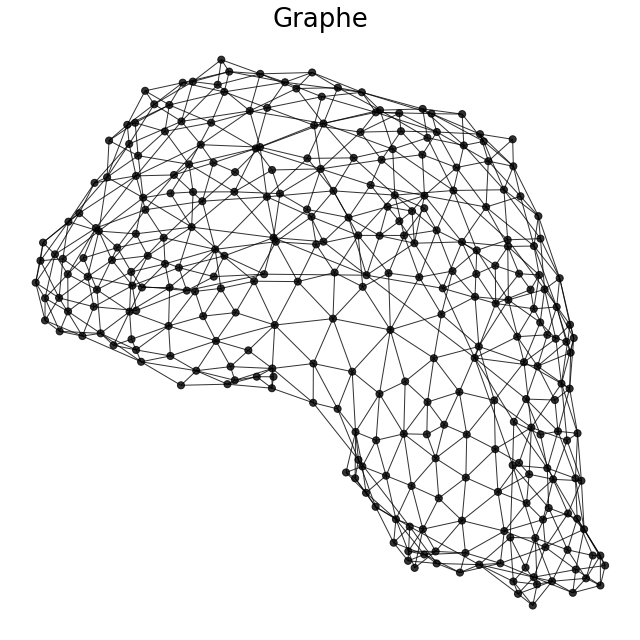

In [4]:
import matplotlib.cm as cmx

pos = nx.spring_layout(G, k=0.05, seed=1)

black = cm = plt.get_cmap('cubehelix')

f = plt.figure(1, figsize=(9, 9))
ax = f.add_subplot(1,1,1)
nx.draw(G, pos, node_size=50, node_color=[255]*len(G),
        alpha=0.8, with_labels=False, arrows=False, cmap=black)
plt.title("Graphe", {"fontsize":26})

plt.axis('off')
f.set_facecolor('w')

f.tight_layout()

In [5]:
# Construit la matrice de covariance Q 
import numpy as np

def buildQ(M, scale, tau_2=2.0, alpha=0.99999):
    D = np.sum(M, axis=1) 
    D = D / scale
    I = np.identity(M.shape[0])
    R = np.reciprocal(D)
    D_ = np.diag(R.T.tolist()[0])
    B = np.dot(M,D_)
    Q = np.dot(tau_2 * D_,(I - alpha* B))
    return(Q)

M = w.sparse.todense()

## Choix du paramètre de dispersion tau, doit être compris entre 0.001 et 0.999.  
## La dépendance entre un point et ses voisins est d'autant plus forte que tau est proche de 0.999

In [6]:
import ipywidgets as widgets

In [7]:
wi = widgets.FloatSlider(value=0.9, min=0.001, max=0.999, step=0.001)
display(wi)

FloatSlider(value=0.9, max=0.999, min=0.001, step=0.001)

In [8]:
# Vous pouvez modifier cette valeur.
# Valeurs d'intérêt: 0.001, 0.9, 0.99, 0.999
tau = wi.value
print(tau)

0.9


In [9]:
M2 = w.sparse.todense()
M2[np.where(M2 != 0)] = 1
Q = buildQ(M2, tau)

## Simule le modèle de dépendances sur graphe

In [10]:
import scipy as sp
def generateCARSimulation(Q, mu, scale=1.):
    L = np.linalg.cholesky(Q)
    I = np.identity(L.shape[0])
    z = sp.random.normal(loc=0,scale=scale,size=L.shape[0])
    v = np.linalg.solve(L.transpose(),z)
    return(v+mu)

z = generateCARSimulation(Q, 0, 1)

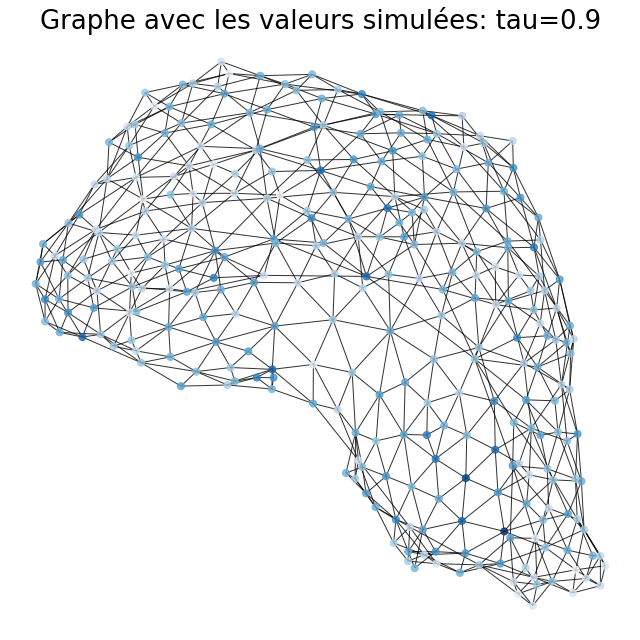

In [11]:
blues = cm = plt.get_cmap('Blues')

f = plt.figure(1, figsize=(9, 9))
ax = f.add_subplot(1,1,1)
nx.draw(G, pos, node_size=50, node_color=z, 
        alpha=0.8, with_labels=False, arrows=False, cmap=blues)
plt.title("Graphe avec les valeurs simulées: tau="+str(tau), {"fontsize":26})

plt.axis('off')
f.set_facecolor('w')

f.tight_layout()

__Plus les valeurs sont élevées, plus les tons des sommets du graphe sont sombres__

## Calcule la corrélation entre une valeur et la moyenne des voisins

In [12]:
import scipy
cor = scipy.stats.pearsonr(z, np.asarray(np.matmul(M, z)).reshape(-1))[0]

## Prédiction linéaire de la valeur d'un sommet par la moyenne de ses voisins: régression
Le graphe ci-dessous, dit "diagramme de Moran", vise à indiquer la dépendance entre la valeur d'un nœud et celle de ces voisins à la fois visuellement et via un indicateur numérique.    
L'idée est d'essayer de prédire la valeur d'un nœud (en ordonnées) à l'aide de la moyenne de ses voisins (en abscisses). S'il existe une relation linéaire entre les deux, le nuage de points doit suivre une orientation le long d'un axe non horizontal, représenté en rouge ici. Dans le cas contraire, le nuage de points est circulaire et/ou l'axe en rouge est horizontal.     
La corrélation indique l'intensité de la dépendance aux voisins.

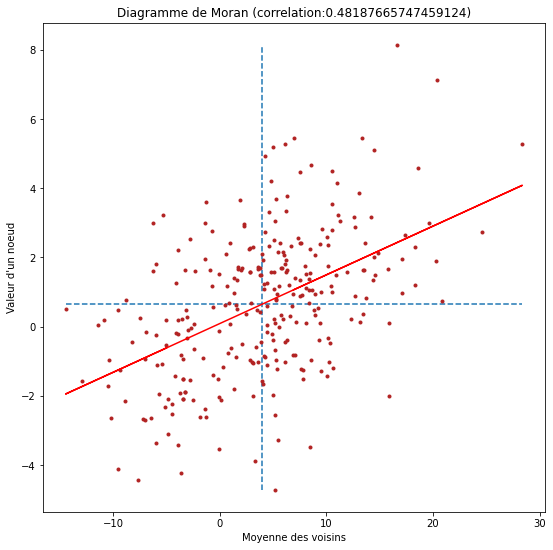

In [13]:
import libpysal as lps

lag_z = lps.weights.lag_spatial(w, z)
b, a = np.polyfit(lag_z, z, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

ax.plot(lag_z, z, '.', color='firebrick')

plt.hlines(z.mean(), lag_z.min(), lag_z.max(), linestyle='--')
plt.vlines(lag_z.mean(), z.min(), z.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(lag_z, a + b*lag_z, 'r')
plt.title('Diagramme de Moran (correlation:' + str(cor) + ")")
plt.ylabel("Valeur d'un noeud")
plt.xlabel('Moyenne des voisins')
plt.show()


__Histogramme des valeurs simulées__

Text(0.5, 1.0, 'Histogramme des valeurs simulées')

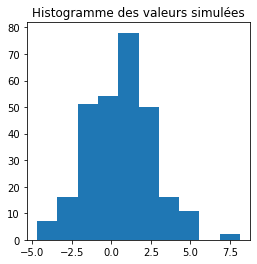

In [14]:
f, ax = plt.subplots(1, figsize=(4, 4))
plt.hist(z)
ax.set_title("Histogramme des valeurs simulées")

Noter qu'on a utilisé une loi normale pour simuler les valeurs, cependant un en sens, chaque valeur simulée a une moyenne qui dépend de celle de ses voisins.    
Ceci n'est pas visible quand on trace l'histogramme de toutes les valeurs simulées : cet histogramme est visuellement semblable à celui qu'on aurait obtenu si toutes les valeurs avaient été simulées indépendamment des valeurs des voisins.

Moyenne empirique des valeurs simulées :

In [15]:
z.mean()

0.6405110068478456